In [1]:
#IMPORTS
import pm4py
import sklearn
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
from itertools import product
from torchmetrics.classification import BinaryF1Score, BinaryConfusionMatrix
from torchmetrics.regression import R2Score, MeanAbsoluteError
import matplotlib.pyplot as plt

# Prepare the Data
The code below is used to generate the CVS file. You can also skip running it and instead load the CSV directly a few cells below.

First, make sure the permit log is in the current directory, then run the code below

In [2]:
travel_permits = pm4py.read_xes('PermitLog.xes.gz')

parsing log, completed traces ::   0%|          | 0/7065 [00:00<?, ?it/s]

First, we make sure we have the prefixes we need, we just want the events leading up to 'Start trip'

In [3]:
travel_prefixes = pm4py.filtering.filter_prefixes(travel_permits, 'Start trip')

In [4]:
#quick check to see if we got what we wanted
i = 39
for e in travel_permits[i]:
    print(e['concept:name'])
print() 
for e in travel_prefixes[i]:
    print(e['concept:name'])

Permit SUBMITTED by EMPLOYEE
Permit FINAL_APPROVED by SUPERVISOR
Start trip
End trip
Declaration SUBMITTED by EMPLOYEE
Declaration FINAL_APPROVED by SUPERVISOR
Request Payment
Payment Handled

Permit SUBMITTED by EMPLOYEE
Permit FINAL_APPROVED by SUPERVISOR


Check if a declaration was submitted before the trip started

In [5]:
decl_bools = np.zeros((7065,1))

for i,t in enumerate(travel_prefixes):
    for e in t:
        if e['concept:name'] == "Declaration SUBMITTED by EMPLOYEE":
            decl_bools[i,0] = 1
            
decl_bools.shape

(7065, 1)

Now extract the features we are interested in from the prefixes:

In [6]:
data_regr, _ = log_to_features.apply(travel_prefixes, parameters={'num_tr_attr': ["RequestedBudget","OverspentAmount"]})
data_class, _ = log_to_features.apply(travel_prefixes, parameters={'num_tr_attr': ["RequestedBudget","Overspent"]})

data_regre = np.array(data_regr).round(2)
data_class = np.array(data_class).round(2)
data_class.shape

(7065, 2)

However, we still need trip duration, which we will need to compute manually. We will use number of days to denote the duration

In [7]:
trip_durations = []
for trace in travel_permits:
    for e in trace:
        if e['concept:name'] == "Start trip": #note the time the trip started
            start_time = e['time:timestamp']
        elif e['concept:name'] == "End trip": #note the time the trip ended
            end_time = e['time:timestamp']
            break
    trip_durations.append((end_time-start_time).days) #save the trip duration in days
    
trip_durations = np.array(trip_durations).reshape((-1,1))
trip_durations.shape

(7065, 1)

And we do the same in order to get the duration between the permit being submitted and the permit being approved

In [8]:
perm_durations = []
for trace in travel_permits:
    started = False
    for e in trace:
        if e['concept:name'].startswith("Permit") and not started: #start time is the first time permit is mentioned
            started = True
            start_time = e['time:timestamp']
            end_time = e['time:timestamp']
        elif e['concept:name'].startswith("Permit"): #end time is the last time permit is mentioned
            end_time = e['time:timestamp']
    perm_durations.append((end_time-start_time).days) #save duration of permit handling in days
    
perm_durations = np.array(perm_durations).reshape((-1,1))
perm_durations.shape

(7065, 1)

Now we merge all the features we extracted into one dataframe

In [9]:
final_data_regr = np.absolute(np.concatenate((decl_bools, trip_durations, perm_durations, data_regr), axis=1))
final_data_class = np.concatenate((decl_bools, trip_durations, perm_durations, data_class), axis=1)
final_data_class.shape

(7065, 5)

Some exploration of the data we have now:

In [10]:
pd.DataFrame(data=final_data_class[:10,:])

,0,1,2,3,4
0,0.0,0.0,0.0,41.61,0.0
1,0.0,31.0,0.0,795.54,0.0
2,0.0,0.0,0.0,51.79,1.0
3,0.0,21.0,0.0,0.00,0.0
4,0.0,364.0,0.0,6020.79,0.0
5,0.0,2.0,0.0,245.06,0.0
6,0.0,6.0,0.0,0.00,0.0
7,0.0,3.0,0.0,1015.98,0.0
8,0.0,5.0,0.0,0.00,0.0
9,0.0,5.0,0.0,156.96,0.0


We can now save the data to CSV:

In [11]:
np.savetxt('ML_data_class.csv', final_data_class, delimiter=',')
np.savetxt('ML_data_regr.csv', final_data_regr, delimiter=',')

# Load the CSV
Or skip the below cell if you already ran the above cells

In [12]:
final_data_class = np.genfromtxt('ML_data_class.csv',delimiter=',')
final_data_regr = np.genfromtxt('ML_data_regr.csv',delimiter=',')
final_data_regr.shape

(7065, 5)

# Train the ML model
First, we split into train, test and validation sets. We do not shuffle because for process mining it is important that the validation and test sets are further in the future than the training set. The training set is 75%, validation 12.5%, and test set 12.5%.

In [13]:
X_train, X_valtest, y_train, y_valtest = sklearn.model_selection.train_test_split(final_data_class[:,:-1], final_data_class[:,-1], 
                                                                                  train_size=0.75, shuffle=False)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_valtest, y_valtest, train_size=0.5, shuffle=False)

Next, we do a parameter search and choose the best parameters based on performance on the validation set. The score metric here has a maximum value of 1.0 and no minimum value.

In [14]:
##no gridsearchcv because it doesn't allow for a validation set
#best_score = -10000
#for n_est, min_split in product([25,50,100,200], [1,20,50]):
#    model = RandomForestRegressor(n_estimators = n_est, min_samples_split = min_split)
#    model.fit(X_train, y_train)
#    score = model.score(X_val, y_val)
#    print("n_estimators: {}, min_samples_split: {}, score: {}".format(n_est, min_split, score))
#    if score > best_score:
#        best_score = score
#        best_param = n_est, min_split

Now we take the model with the best performing parameters and test its performance on the test set

In [15]:
#best_model = RandomForestRegressor(n_estimators = best_param[0], min_samples_split = best_param[1])
#best_model.fit(X_train, y_train)
#best_model.score(X_test, y_test)

This score metric isn't the most intuitive, so let's compute mean absolute error on the test set as well.

In [16]:
#mean_absolute_error(y_test, best_model.predict(X_test))

In [17]:
## Model Definition ##
import torch
from torchsummary import summary

In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [19]:
#device = torch.device('cpu')

In [20]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.input_layer = torch.nn.Linear(4,16)
        self.hidden_layer = torch.nn.Linear(16, 16)
        self.output_layer = torch.nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = torch.sigmoid(self.output_layer(x))
        return x


#summary(model, input_size=(4,))

In [21]:
## LOSS Definition ##

In [22]:
## Training ##
#Trainer class from the practical, adapted slightly because we do not have a validation set

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 epochs: int,
                 mean_train_losses,
                 mean_val_losses
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.epochs = epochs
        self.mean_train_losses = mean_train_losses
        self.mean_val_losses = mean_val_losses

    def run_trainer(self):
        self.model = self.model.float()
        for epoch in tqdm(range(self.epochs)):
            
            self.model.train()  # train mode
            #idx = [range(X_train.shape[0])]
            #batches = idx.split(self.batch_size)
            
            train_losses=[]
            for batch in range(X_train.shape[0]):
                #X_train.astype(double), y_train.astype(double)
                x,y=torch.as_tensor(X_train[batch]), torch.as_tensor(y_train[batch])
                input, target = x.to(self.device), y.to(self.device).reshape((-1,1)).squeeze(-1)  # send to device (GPU or CPU)
                #print(input)
                #print(target)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input.float())  # one forward pass
                #print(out)
                loss = self.criterion(out, target.float()).cpu()  # calculate loss

                train_losses.append(float(loss))
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

            self.mean_train_losses.append(np.mean(train_losses))
            
            val_losses=[]
            for batch in range(X_val.shape[0]):
                self.model.eval()
                #X_val.astype(double), y_val.astype(double)
                x,y=torch.as_tensor(X_val[batch]), torch.as_tensor(y_val[batch])
                input, target = x.to(self.device), y.to(self.device).reshape((-1,1)).squeeze(-1)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input.float())  # one forward pass
                loss = self.criterion(out, target.float()).cpu()  # calculate loss

                val_losses.append(float(loss))
                
            print(f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}', end=' ')
            print(f"TRAIN LOSS: {np.mean(train_losses):.4f}")
            print(f"VAL LOSS: {np.mean(val_losses):.4f}")
            self.mean_val_losses.append(np.mean(val_losses))


    def test(self):
        model = self.model.to("cpu")
        model.eval()
        model = model.float()
        test_losses=[]
        y_test_pred=[]
        for batch in range(X_test.shape[0]):
            #self.model.eval()
            #X_test.astype(double), y_test.astype(double)
            x,y=torch.as_tensor(X_test[batch]).clone().detach().cpu(), torch.as_tensor(y_test[batch]).clone().detach().cpu()
            input, target = x.to(self.device), y.to(self.device).reshape((-1,1)).squeeze(-1)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = model(input.float().cpu())  # one forward pass
            loss = self.criterion(out.clone().detach().cpu(), target.float().clone().detach().cpu())  # calculate loss
            y_test_pred.append(out.clone().detach().numpy())

            test_losses.append(float(loss))
        return y_test_pred
                
        print(f"LOSS: {np.mean(test_losses):.4f}")

  5%|████▏                                                                              | 1/20 [00:10<03:24, 10.75s/it]

EPOCH: 01/20 TRAIN LOSS: 5.4370
VAL LOSS: 0.8584


 10%|████████▎                                                                          | 2/20 [00:22<03:22, 11.23s/it]

EPOCH: 02/20 TRAIN LOSS: 0.8741
VAL LOSS: 0.6055


 15%|████████████▍                                                                      | 3/20 [00:33<03:13, 11.37s/it]

EPOCH: 03/20 TRAIN LOSS: 0.6343
VAL LOSS: 0.5900


 20%|████████████████▌                                                                  | 4/20 [00:45<03:02, 11.41s/it]

EPOCH: 04/20 TRAIN LOSS: 0.6127
VAL LOSS: 0.5860


 25%|████████████████████▊                                                              | 5/20 [00:56<02:52, 11.48s/it]

EPOCH: 05/20 TRAIN LOSS: 0.6107
VAL LOSS: 0.5855


 30%|████████████████████████▉                                                          | 6/20 [01:08<02:41, 11.51s/it]

EPOCH: 06/20 TRAIN LOSS: 0.6076
VAL LOSS: 0.5850


 35%|█████████████████████████████                                                      | 7/20 [01:20<02:30, 11.55s/it]

EPOCH: 07/20 TRAIN LOSS: 0.6058
VAL LOSS: 0.5849


 40%|█████████████████████████████████▏                                                 | 8/20 [01:31<02:18, 11.58s/it]

EPOCH: 08/20 TRAIN LOSS: 0.6037
VAL LOSS: 0.5848


 45%|█████████████████████████████████████▎                                             | 9/20 [01:43<02:06, 11.54s/it]

EPOCH: 09/20 TRAIN LOSS: 0.6022
VAL LOSS: 0.5852


 50%|█████████████████████████████████████████                                         | 10/20 [01:54<01:55, 11.51s/it]

EPOCH: 10/20 TRAIN LOSS: 0.6011
VAL LOSS: 0.5851


 55%|█████████████████████████████████████████████                                     | 11/20 [02:06<01:43, 11.50s/it]

EPOCH: 11/20 TRAIN LOSS: 0.6016
VAL LOSS: 0.5851


 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:17<01:31, 11.49s/it]

EPOCH: 12/20 TRAIN LOSS: 0.6014
VAL LOSS: 0.5849


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [02:29<01:20, 11.53s/it]

EPOCH: 13/20 TRAIN LOSS: 0.6007
VAL LOSS: 0.5848


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [02:40<01:09, 11.56s/it]

EPOCH: 14/20 TRAIN LOSS: 0.6014
VAL LOSS: 0.5848


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [02:52<00:57, 11.53s/it]

EPOCH: 15/20 TRAIN LOSS: 0.6012
VAL LOSS: 0.5848


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:03<00:45, 11.50s/it]

EPOCH: 16/20 TRAIN LOSS: 0.6014
VAL LOSS: 0.5848


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [03:15<00:34, 11.54s/it]

EPOCH: 17/20 TRAIN LOSS: 0.6014
VAL LOSS: 0.5849


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [03:27<00:23, 11.58s/it]

EPOCH: 18/20 TRAIN LOSS: 0.6017
VAL LOSS: 0.5849


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [03:38<00:11, 11.51s/it]

EPOCH: 19/20 TRAIN LOSS: 0.6014
VAL LOSS: 0.5849


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:49<00:00, 11.50s/it]

EPOCH: 20/20 TRAIN LOSS: 0.6011
VAL LOSS: 0.5849


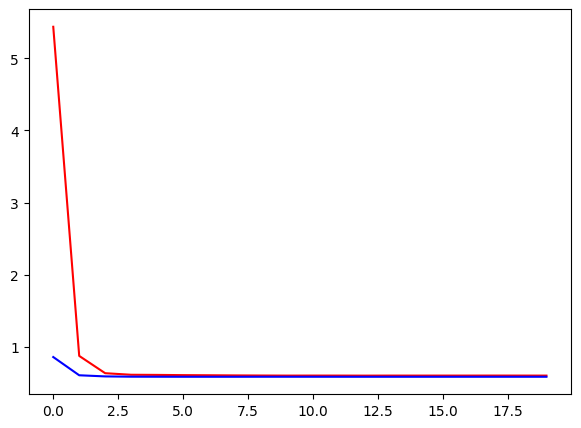

In [23]:
model_class = Model().to(device)
criterion_class = torch.nn.BCELoss()
optimizer_class = torch.optim.Adam(model_class.parameters(), lr=0.001)#, momentum=0.5, weight_decay=1e-5)
trainer_class = Trainer(model=model_class,
                  device=device,
                  criterion=criterion_class,
                  optimizer=optimizer_class,
                  epochs=20,
                  mean_train_losses=[],
                  mean_val_losses=[]
                 )
trainer_class.run_trainer()
class_pred = trainer_class.test()

(0.5, 1.0)

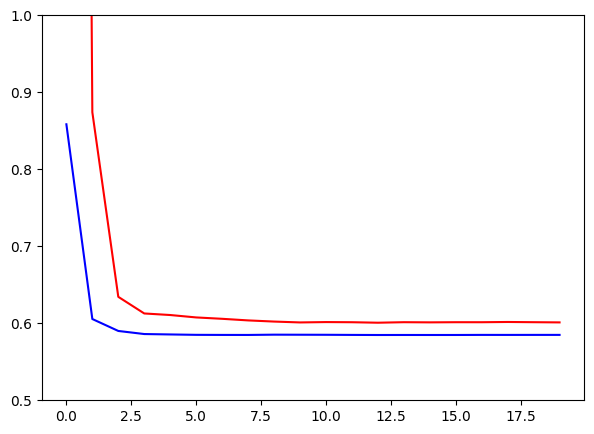

In [35]:
plt.figure(0, figsize=(7,5))
plt.plot(trainer_class.mean_train_losses, 'red')
plt.plot(trainer_class.mean_val_losses, 'blue')
plt.ylim(0.5,1)

In [24]:
metric = BinaryF1Score(threshold=0.5)
metric(torch.as_tensor(1-np.array(class_pred)[:,0]), torch.as_tensor(1-y_test))

tensor(0.9147)

In [25]:
metric = BinaryConfusionMatrix()
metric(torch.as_tensor(np.array(class_pred)[:,0]), torch.as_tensor(y_test))

tensor([[745,   0],
        [139,   0]])

#Regression

In [26]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [27]:
class Model_Regress(torch.nn.Module):
    def __init__(self):
        super(Model_Regress, self).__init__()
        self.input_layer = torch.nn.Linear(4,16)
        self.hidden_layer = torch.nn.Linear(16, 16)
        self.output_layer = torch.nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x


#summary(model, input_size=(4,))

  5%|████▏                                                                              | 1/20 [00:11<03:36, 11.40s/it]

EPOCH: 01/20 TRAIN LOSS: 606.3313
VAL LOSS: 306.0196


 10%|████████▎                                                                          | 2/20 [00:23<03:28, 11.56s/it]

EPOCH: 02/20 TRAIN LOSS: 601.5247
VAL LOSS: 305.9178


 15%|████████████▍                                                                      | 3/20 [00:34<03:18, 11.69s/it]

EPOCH: 03/20 TRAIN LOSS: 600.7846
VAL LOSS: 305.7895


 20%|████████████████▌                                                                  | 4/20 [00:46<03:07, 11.73s/it]

EPOCH: 04/20 TRAIN LOSS: 600.4540
VAL LOSS: 305.7055


 25%|████████████████████▊                                                              | 5/20 [00:58<02:54, 11.66s/it]

EPOCH: 05/20 TRAIN LOSS: 600.4881
VAL LOSS: 305.6076


 30%|████████████████████████▉                                                          | 6/20 [01:09<02:42, 11.59s/it]

EPOCH: 06/20 TRAIN LOSS: 600.2840
VAL LOSS: 305.5559


 35%|█████████████████████████████                                                      | 7/20 [01:21<02:30, 11.59s/it]

EPOCH: 07/20 TRAIN LOSS: 600.2814
VAL LOSS: 305.6280


 40%|█████████████████████████████████▏                                                 | 8/20 [01:32<02:19, 11.63s/it]

EPOCH: 08/20 TRAIN LOSS: 600.1345
VAL LOSS: 305.5434


 45%|█████████████████████████████████████▎                                             | 9/20 [01:44<02:07, 11.60s/it]

EPOCH: 09/20 TRAIN LOSS: 600.2273
VAL LOSS: 305.4676


 50%|█████████████████████████████████████████                                         | 10/20 [01:56<01:55, 11.58s/it]

EPOCH: 10/20 TRAIN LOSS: 600.0305
VAL LOSS: 305.5937


 55%|█████████████████████████████████████████████                                     | 11/20 [02:07<01:44, 11.66s/it]

EPOCH: 11/20 TRAIN LOSS: 599.9677
VAL LOSS: 305.4534


 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:19<01:32, 11.60s/it]

EPOCH: 12/20 TRAIN LOSS: 600.0073
VAL LOSS: 305.4219


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [02:30<01:20, 11.52s/it]

EPOCH: 13/20 TRAIN LOSS: 599.9160
VAL LOSS: 305.5573


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [02:42<01:09, 11.52s/it]

EPOCH: 14/20 TRAIN LOSS: 599.9063
VAL LOSS: 305.4355


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [02:53<00:57, 11.50s/it]

EPOCH: 15/20 TRAIN LOSS: 599.9504
VAL LOSS: 305.4274


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:05<00:45, 11.49s/it]

EPOCH: 16/20 TRAIN LOSS: 599.9210
VAL LOSS: 305.5416


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [03:16<00:34, 11.52s/it]

EPOCH: 17/20 TRAIN LOSS: 599.8115
VAL LOSS: 305.4675


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [03:28<00:23, 11.58s/it]

EPOCH: 18/20 TRAIN LOSS: 599.8738
VAL LOSS: 305.3901


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [03:40<00:11, 11.63s/it]

EPOCH: 19/20 TRAIN LOSS: 599.8914
VAL LOSS: 305.4646


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:51<00:00, 11.58s/it]

EPOCH: 20/20 TRAIN LOSS: 599.8119
VAL LOSS: 305.3637


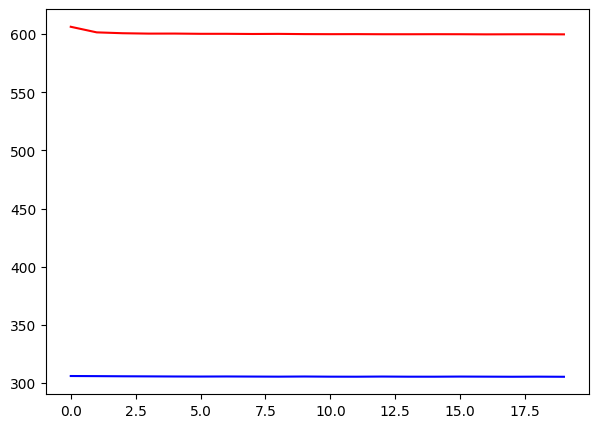

In [28]:
X_train, X_valtest, y_train, y_valtest = sklearn.model_selection.train_test_split(final_data_regr[:,:-1], final_data_regr[:,-1], 
                                                                                 train_size=0.75, shuffle=False)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_valtest, y_valtest, train_size=0.5, shuffle=False)
model_regress = Model_Regress().to(device)
criterion_regress = torch.nn.L1Loss()
optimizer_regress = torch.optim.Adam(model_regress.parameters(), lr=0.001)#, momentum=0.5, weight_decay=1e-5)
trainer_regress = Trainer(model=model_regress,
                  device=device,
                  criterion=criterion_regress,
                  optimizer=optimizer_regress,
                  epochs=20,
                  mean_train_losses=[],
                  mean_val_losses=[]
                 )

trainer_regress.run_trainer()
regress_pred = trainer_regress.test()

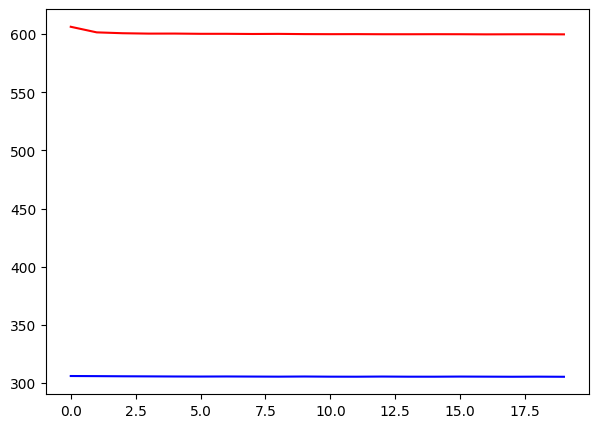

In [34]:
plt.figure(0, figsize=(7,5))
plt.plot(trainer_regress.mean_train_losses, 'red')
plt.plot(trainer_regress.mean_val_losses, 'blue')
#plt.ylim(0,1)

In [29]:
metric = R2Score()
metric(torch.as_tensor(np.array(regress_pred)[:,0]), torch.as_tensor(y_test))

tensor(0.1635)

In [30]:
metric = MeanAbsoluteError()
metric(torch.as_tensor(np.array(regress_pred)[:,0]), torch.as_tensor(y_test))

tensor(539.3689)

In [31]:
#TODO:
#Evaluation metrics: R2 and MAE for regression; F1 score (and mean accuracy) for classification
#Plots: Confusion matrix & Training graphs